In [1]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import numpy as np

In [2]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# load dataset
df = pd.read_csv("diabetes.csv", header=None, names=col_names)
#The header=None argument specifies that the dataset does not have a header row, and the names=col_names argument assigns
#the column names from the col_names list to the DataFrame.
df = df.drop(index=0)
df

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
764,10,101,76,48,180,32.9,0.171,63,0
765,2,122,70,27,0,36.8,0.34,27,0
766,5,121,72,23,112,26.2,0.245,30,0
767,1,126,60,0,0,30.1,0.349,47,1


In [3]:
df.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1


In [4]:
#split dataset in features and target variable
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
X = df[feature_cols] # Features
y = df.label # Target variable

In [5]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [6]:
# Create Decision Tree classifer object
classifier = DecisionTreeClassifier()

# Train Decision Tree Classifer
classifier = classifier.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = classifier.predict(X_test)


In [7]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6796536796536796


In [8]:
#Visualize the decision tree

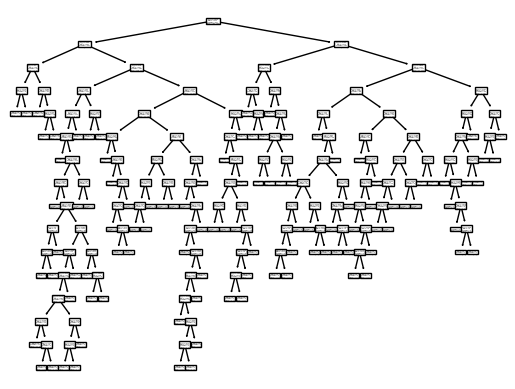

In [9]:
from sklearn import tree
from matplotlib import pyplot as plt

tree.plot_tree(classifier)
plt.show()

In [10]:
from sklearn.tree import export_text

rules = export_text(classifier, feature_names=feature_cols, max_depth=15)
print(rules)

|--- glucose <= 129.50
|   |--- bmi <= 26.30
|   |   |--- bmi <= 9.10
|   |   |   |--- glucose <= 114.50
|   |   |   |   |--- class: 0
|   |   |   |--- glucose >  114.50
|   |   |   |   |--- class: 1
|   |   |--- bmi >  9.10
|   |   |   |--- pedigree <= 0.67
|   |   |   |   |--- class: 0
|   |   |   |--- pedigree >  0.67
|   |   |   |   |--- pedigree <= 0.71
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- pedigree >  0.71
|   |   |   |   |   |--- class: 0
|   |--- bmi >  26.30
|   |   |--- age <= 27.50
|   |   |   |--- bmi <= 45.40
|   |   |   |   |--- pregnant <= 7.00
|   |   |   |   |   |--- bp <= 12.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- bp >  12.00
|   |   |   |   |   |   |--- pedigree <= 1.27
|   |   |   |   |   |   |   |--- bmi <= 30.95
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- bmi >  30.95
|   |   |   |   |   |   |   |   |--- bp <= 53.00
|   |   |   |   |   |   |   |   |   |--- pregnant <= 2.50
|   |   |   | 

In [15]:
def stringify_node(node):
    '''
    Parameters:
        node: tuple of (feature, operator, threshold)
    Returns:
        String representation of the branching condition of the node
    '''
    feature, operator, threshold = node
    return f"{feature} {operator} {threshold:.2f}"

def conjoin_conditions(conditions):
    '''
    Parameters:
        conditions: list of branching conditions
    Returns:
        String representation of the conjunction of the boolean conditions
    '''
    return " and ".join(conditions)

def is_node_missing(node):
    '''
    Parameters:
        node: tuple of (feature, operator, threshold)
    Returns:
        true if the node is -1, false otherwise
    '''
    return node == -1

def get_rules(tree, feature_names):
    '''
    Parameters:
        tree: DecisionTreeClassifier
        feature_names: list of feature names
    Returns:
        List of rules in the form of strings
    '''
    # indexes of left subtrees
    left = tree.tree_.children_left
    # indexes of right subtrees
    right = tree.tree_.children_right
    # `threshold` values at each node
    threshold = tree.tree_.threshold
    # features used for splitting at each node
    # ordered by node id
    features = [
        feature_names[i]
        for i in tree.tree_.feature
    ]

    def traverse_subtree(node_id, subtree, path, operator):
        '''
        Get the rules of a subtree

        Parameters:
            node_id: id of the current node
            subtree: left or right subtree
            path: list of nodes traversed so far
            operator: "<=" if left subtree and ">" if right subtree
        Returns:
            List of rules
        '''
        node = (features[node_id], operator, threshold[node_id])
        return traverse(
            subtree[node_id],
            path + [node]
        )

    def traverse(node_id=0, rules=[]):
        '''
        Recursively get the rules of a tree
        '''
        # base case of the recursion
        is_leaf = (
            is_node_missing(left[node_id])
            and is_node_missing(right[node_id])
        )
        if is_leaf:
            return [rules]
        else:
            # get the rules of the left subtree
            rules_in_left_subtree = traverse_subtree(node_id, left, rules, "<=")
            # get the rules of the right subtree
            rules_in_right_subtree = traverse_subtree(node_id, right, rules, ">")
            # return rules of both subtrees
            return rules_in_left_subtree + rules_in_right_subtree

    # get the paths in the tree starting from the root node and traversing tree
    paths = traverse()

    # conjoin branching conditions of each node in a path for all paths 
    rules = [
        conjoin_conditions([
            stringify_node(node)
            for node in path
        ])
        for path in paths
    ]

    return rules

# get the every rule represented as paths in the tree
rules = get_rules(classifier, feature_names=feature_cols)

for rule in rules:
    print(rule)

glucose <= 129.50 and bmi <= 26.30 and bmi <= 9.10 and glucose <= 114.50
glucose <= 129.50 and bmi <= 26.30 and bmi <= 9.10 and glucose > 114.50
glucose <= 129.50 and bmi <= 26.30 and bmi > 9.10 and pedigree <= 0.67
glucose <= 129.50 and bmi <= 26.30 and bmi > 9.10 and pedigree > 0.67 and pedigree <= 0.71
glucose <= 129.50 and bmi <= 26.30 and bmi > 9.10 and pedigree > 0.67 and pedigree > 0.71
glucose <= 129.50 and bmi > 26.30 and age <= 27.50 and bmi <= 45.40 and pregnant <= 7.00 and bp <= 12.00
glucose <= 129.50 and bmi > 26.30 and age <= 27.50 and bmi <= 45.40 and pregnant <= 7.00 and bp > 12.00 and pedigree <= 1.27 and bmi <= 30.95
glucose <= 129.50 and bmi > 26.30 and age <= 27.50 and bmi <= 45.40 and pregnant <= 7.00 and bp > 12.00 and pedigree <= 1.27 and bmi > 30.95 and bp <= 53.00 and pregnant <= 2.50 and insulin <= 179.50
glucose <= 129.50 and bmi > 26.30 and age <= 27.50 and bmi <= 45.40 and pregnant <= 7.00 and bp > 12.00 and pedigree <= 1.27 and bmi > 30.95 and bp <= 53.00